# Predicción Precios Argentina - MD 2022

Notebook para la competencias de [Kaggle](https://www.kaggle.com/competitions/fcen-md-2022-prediccion-precio-de-propiedades/leaderboard) de la materia MD de la maestria de DM de la UBA.

Autor: Tomás Delvechio

## Configuración de la notebook

A continuación se definen configuraciones que afectaran el resto del notebook.

In [519]:
# Libs estandar de pythons, utiles en todo el notebook
from datetime import date
import os.path
from shutil import which
import sys

# No tocar
EJECUTA_COLAB = 'google.colab' in sys.modules
ESTA_KAGGLE = not EJECUTA_COLAB \
    and which("kaggle") is not None \
    and os.path.exists(os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json"))
#ENTORNO_DESARROLLO = "Desarrollo"
#ENTORNO_PRUEBA = "Prueba"
#ENTORNO_PRODUCCION = "Produccion"

In [520]:
if EJECUTA_COLAB:
    ! pip install numpy pandas matplotlib scipy scikit-learn nltk seaborn


In [521]:
# Libs de data science
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


# Funciones para texto
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize


[nltk_data] Downloading package punkt to /home/tomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Funciones generales

definición de algunas funciones que se utilizaran de forma general

In [522]:
def comparar_listas(l1, l2):
    """Compara la primer lista contra la segunda y retorna lo que le falta y lo que le sobra"""
    lo_que_le_falta = set(l2) - set(l1)
    lo_que_le_sobra = set(l1) - set(l2)
    return lo_que_le_falta, lo_que_le_sobra

def comparar_barrios(lista_barrios_uno, lista_barrios_dos):
    return comparar_listas(lista_barrios_uno, lista_barrios_dos)


def graficar_histogramas(df, columns, ds_type="entrenamiento"):
    for column in columns:
        ax = df[column].plot.hist()
        ax.set_title(f"Histograma de {column} - {ds_type}")
        ax.set_xlabel(f"Cantidad de {column}")
        plt.show()


def graficar_scatters(df, columns, ds_type="entrenamiento", son_fechas=False):
    #print(df[columns].corr()['rooms']['bedrooms'])
    correlations_df = df[columns].corr()
    for column_in_x in columns:
        for column_in_y in columns[columns.index(column_in_x)+1:]:
            #print(column_in_x, column_in_y)
            #print(np.corrcoef(column_in_x, column_in_y))
            if son_fechas:
                plt.plot_date(df[column_in_x], df[column_in_y])
            else:
                plt.scatter(df[column_in_x], df[column_in_y])
                plt.title(f"Diagrama de dispersión entre {column_in_x} / {column_in_y} - {ds_type}")
                plt.text(-0.1, 0.7, f"r = {round(correlations_df[column_in_x][column_in_y], 3)}", fontsize=10, ha='center', va='center', transform=ax.transAxes)
                plt.xlabel(column_in_x)
                plt.ylabel(column_in_y)
            plt.show()


def graficar_correlograma(df, columns, annot=True):
    sns.heatmap(df[columns].corr(), annot=annot)


## Configuraciones editables

Estas variables pueden ser editadas para cambiar comportamientos del notebook

In [523]:
# Editar para cambiar comportamiento
#ENTORNO = ENTORNO_PRUEBA
ELIMINAR_COLS_CON_NAN_PROPORCION = 0.49 # Proporción mínima de NaNs presentes para eliminar una columna


## Datasets

Se listan todos los datasets a considerar a continuación en un dict

In [524]:
datasets = {

    "input": {

        # Dataset de entrenamiento
        "entrenamiento": {
            "nombre": "properati_ar",
            "archivo": 'ar_properties.csv',
            "archivo_comprimido": "ar_properties.csv.gz",
            "comprimido": "gz",
            "url": "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz",
        },

        # Dataset de prueba
        "prueba": {
            "nombre": "testing",
            "archivo": "cocheras.csv",
            "archivo_comprimido": None,
            "comprimido": None,
            "url": None,
        },

    },

    "output": {

        # Dataset de la fase de Limpieza inicial
        "dataset_limpio": {
            "nombre": "dataset_cocheras_limpio",
            "archivo": "dataset_cocheras_limpio.csv",
            "comprimido": False,
            "url": None,
        },

        # Dataset para subir a Kaggle
        "solucion": {
            "nombre": "soluciones",
            "archivo": "solucion_cocheras.csv",
            "comprimido": False,
            "url": None,
        },

    },

}

### Descarga de los datasets

Controla si los datasets estan o no descargado, en caso de no estarlo, los descarga y descomprime

In [525]:
if EJECUTA_COLAB:
    DOWNLOAD_PATH = '/content'
else:
    DOWNLOAD_PATH = '.data/'
    # tratamos de crear el dir por si es la 1era vez que ejecuta
    ! mkdir -p $DOWNLOAD_PATH

for tipo, ds in datasets["input"].items():
    print(f"Verificando ds para {tipo}: {ds['nombre']}")

    fulllpath = os.path.join(
        DOWNLOAD_PATH, f"{ds['archivo_comprimido']}")
    fulllpath_raw = os.path.join(
        DOWNLOAD_PATH, ds["archivo"])

    if os.path.exists(fulllpath_raw):
        # skip download
        print(f"    Dataset {ds['nombre']} ({fulllpath_raw}) ya descargado anteriormente... No se descarga.")
    else:
        url = ds["url"]
        print(f"Descargando {ds['nombre']} desde {url}")
        ! wget -N -O $fulllpath -q $url
        print(f"DS {ds['nombre']} descargado correctamente")
        if ds["comprimido"] == "gz":
            ! gzip -d -f $fulllpath
        elif ds["comprimido"] == "zip":
            ! unzip -n $fulllpath -d ".data/"
            ! rm $fulllpath

archivo_entrenamiento = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["entrenamiento"]["archivo"])
archivo_prueba = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["prueba"]["archivo"])


Verificando ds para entrenamiento: properati_ar
    Dataset properati_ar (.data/ar_properties.csv) ya descargado anteriormente... No se descarga.
Verificando ds para prueba: testing
    Dataset testing (.data/cocheras.csv) ya descargado anteriormente... No se descarga.


Preparamos el archivo de salida

In [526]:
archivo_limpieza_inicial = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["dataset_limpio"]["archivo"])
archivo_salida = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["solucion"]["archivo"])

print(f"Archivo intermedio de limpieza inicial: {archivo_limpieza_inicial}")
print(f"Archivo de soluciones: {archivo_salida}")


Archivo intermedio de limpieza inicial: .data/dataset_cocheras_limpio.csv
Archivo de soluciones: .data/solucion_cocheras.csv


### Lectura de datos

Se levantan los df de prueba y entrenamiento. No se levantan con el índice `index_col="id"` dado que la [página de properati](https://www.properati.com.ar/data) aclara que podria no ser único.

In [527]:
df_entrenamiento_crudo = pd.read_csv(archivo_entrenamiento)#, index_col="id")
df_prueba_inicial = pd.read_csv(archivo_prueba)#, index_col="id")

#if (ENTORNO == ENTORNO_DESARROLLO):
#    # filtro para pruebas rápidas
#    df_entrenamiento_crudo = df_entrenamiento_crudo.loc[(df_entrenamiento_crudo.l2 == "Córdoba") & (
#        df_entrenamiento_crudo.operation_type == 'Venta') & (df_entrenamiento_crudo.property_type == 'Casa')]
#    df_entrenamiento_crudo.shape

assert df_entrenamiento_crudo.shape[1] == 25, "El ds de entrenamiento no tiene 25 atributos. Revisar."
assert df_prueba_inicial.shape[1] == 25, "El ds de prueba no tiene 28 atributos. Revisar."
assert len(df_entrenamiento_crudo) == 1000000, "El dataset no levantó el millon de registros."


In [528]:
print("Columnas en pruebas que no estan en entrenamiento", set(df_prueba_inicial.columns) - set(df_entrenamiento_crudo.columns))
print("Columnas en entrenamiento que no estan en pruebas", set(df_entrenamiento_crudo.columns) - set(df_prueba_inicial.columns))


Columnas en pruebas que no estan en entrenamiento {'details', 'services', 'additionals'}
Columnas en entrenamiento que no estan en pruebas {'l5', 'l6', 'l4'}


No usaremos estas columnas, asi que las removemos

In [529]:
columnas_borrar_pruebas = list(set(df_prueba_inicial.columns) - set(df_entrenamiento_crudo.columns))
columnas_borrar_entrenamiento = list(set(df_entrenamiento_crudo.columns) - set(df_prueba_inicial.columns))
df_prueba_inicial = df_prueba_inicial[df_prueba_inicial.columns.drop(columnas_borrar_pruebas)]
df_entrenamiento_crudo = df_entrenamiento_crudo[df_entrenamiento_crudo.columns.drop(columnas_borrar_entrenamiento)]


In [530]:
print("Columnas en pruebas que no estan en entrenamiento", set(df_prueba_inicial.columns) - set(df_entrenamiento_crudo.columns))
print("Columnas en entrenamiento que no estan en pruebas", set(df_entrenamiento_crudo.columns) - set(df_prueba_inicial.columns))


Columnas en pruebas que no estan en entrenamiento set()
Columnas en entrenamiento que no estan en pruebas set()


### Datos externos

In [531]:
# barrios caba segun el gcba
barrios_caba = [
    "Agronomía",
    "Almagro",
    "Balvanera",
    "Barracas",
    "Belgrano",
    "Boedo",
    "Caballito",
    "Chacarita",
    "Coghlan",
    "Colegiales",
    "Constitución",
    "Flores",
    "Floresta",
    "Boca",
    "Paternal",
    "Liniers",
    "Mataderos",
    "Monte Castro",
    "Monserrat",
    "Nueva Pompeya",
    "Nuñez",
    "Palermo",
    "Parque Avellaneda",
    "Parque Chacabuco",
    "Parque Chas",
    "Parque Patricios",
    "Puerto Madero",
    "Recoleta",
    "Retiro",
    "Saavedra",
    "San Cristobal",
    "San Nicolás",
    "San Telmo",
    "Versalles",
    "Villa Crespo",
    "Villa Devoto",
    "Villa General Mitre",
    "Villa Lugano",
    "Villa Luro",
    "Villa Ortuzar",
    "Villa Pueyrredon",
    "Villa Real",
    "Villa Riachuelo",
    "Villa Santa Rita",
    "Villa Soldati",
    "Villa Urquiza",
    "Villa del Parque",
    "Vélez Sarsfield",
]

# Análisis y Limpieza inicial

La idea de esta sección es una exploración de los datos para tratar que el dataset de entrenamiento se parezca al dataset a predecir.

## Control de columnas y registros entre datasets

Los tipos de datos de las columnas de entrenamiento:

In [532]:
df_entrenamiento_crudo.dtypes


id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
dtype: object

En principio hay preeminencia de columnas no numéricas.

In [533]:
df_entrenamiento_crudo.dtypes.value_counts()


object     14
float64     8
dtype: int64

In [534]:
df_entrenamiento_crudo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1000000 non-null  object 
 1   ad_type          1000000 non-null  object 
 2   start_date       1000000 non-null  object 
 3   end_date         1000000 non-null  object 
 4   created_on       1000000 non-null  object 
 5   lat              894233 non-null   float64
 6   lon              894191 non-null   float64
 7   l1               1000000 non-null  object 
 8   l2               1000000 non-null  object 
 9   l3               965273 non-null   object 
 10  rooms            714179 non-null   float64
 11  bedrooms         649933 non-null   float64
 12  bathrooms        765122 non-null   float64
 13  surface_total    477831 non-null   float64
 14  surface_covered  487756 non-null   float64
 15  price            958243 non-null   float64
 16  currency         95

Vamos a describir a continuación cada columna. El Id no se lista pero es la columna 25. No es el index del dataframe.

| # | Columna | Descripción |
|---|---------|-------------|
| 1 | ad_type   | Tipo de publicación o aviso |
|---|---------|-------------|
| 2 | start_date    | Fecha de alta |
| 3 | end_date  | Fecha de baja |
| 4 | created_on    | Fecha de alta de la primer versión |
|---|---------|-------------|
| 5 | lat   | Latitud |
| 6 | lon   | Longitud |
| 7 | l1    | País |
| 8 | l2    | Provincia |
| 9 | l3    | Ciudad |
|---|---------|-------------|
| 13 | rooms | Cantidad de ambientes |
| 14 | bedrooms  | Cantidad de dormitorios |
| 15 | bathrooms | Cantidad de baños |
| 16 | surface_total | Superficie en m² |
| 17 | surface_covered   | Superficie cubierta en m² |
| 18 | price | Precio publicado |
| 19 | currency  | Moneda del precio |
| 20 | price_period  | si el precio es diario, semanal, mensual |
| 21 | title | título del anuncio |
| 22 | description   | descripcion del anuncio |
| 23 | property_type | Si es casa, depto, PH... |
| 24 | operation_type    | Si es venta, alquiler... |

Agrupamos los diferentes conceptos del dataset por columnas relacionadas:

In [535]:
columnas_id = ["id", "ad_type", ]
columnas_fecha = ["start_date", "end_date", "created_on", ]
columnas_ubicacion = [
    "lat",
    "lon",
    "l1",
    "l2",
    "l3",
]
columnas_publicacion = [
    "price",
    "currency",
    "price_period",
    "title",
    "description",
    "property_type",
    "operation_type",
]

columnas_de_propiedad = [
    'rooms',
    'bedrooms',
    'bathrooms',
    'surface_total',
    'surface_covered',
]


In [536]:
def ver_columnas(df, preffix='', suffix=''):
    print(preffix, df.columns, suffix)

ver_columnas(df_entrenamiento_crudo, "Entrenamiento:")
ver_columnas(df_prueba_inicial, "Prueba:")

le_falta_a_entrenamiento, le_sobra_a_entrenamiento = comparar_listas(df_entrenamiento_crudo.columns,
                df_prueba_inicial.columns)

print("Columnas en Pruebas pero NO en entrenamiento: ", le_falta_a_entrenamiento)
print("Columnas en Entrenamiento pero NO en pruebas: ", "No Hay" if len(
    le_sobra_a_entrenamiento) == 0 else le_sobra_a_entrenamiento)


Entrenamiento: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type'],
      dtype='object') 
Prueba: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type'],
      dtype='object') 
Columnas en Pruebas pero NO en entrenamiento:  set()
Columnas en Entrenamiento pero NO en pruebas:  No Hay


¿Cuantos registros tiene cada uno de los datasets?

In [537]:
print(f"Cantidad de registros de Entrenamiento: {len(df_entrenamiento_crudo)}")
print(f"Cantidad de registros de Prueba: {len(df_prueba_inicial)}")


Cantidad de registros de Entrenamiento: 1000000
Cantidad de registros de Prueba: 196


In [538]:
df_prueba_inicial.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,1,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.444290,-34.594721,Argentina,Capital Federal,NaN,...,NaN,12.5,12.5,NaN,USD,NaN,Av San Martin Al 1900 - Cochera en Venta en Vi...,"---<br>Se deja constancia que las medidas, sup...",Departamento,Venta
1,2,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.593906,-34.644525,Argentina,Capital Federal,Moron,...,NaN,NaN,NaN,NaN,USD,NaN,Carlos Tejedor Al 1400 - Cochera en Venta en H...,Cochera semi-cubierta en planta baja- unidad f...,Departamento,Venta
2,3,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.473594,-34.629289,Argentina,Capital Federal,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,"Bacacay Al 3100 - Cochera en Venta en Flores, ...",COCHERA FIJA CUBIERTA A LA VENTA EN EXCELENTE ...,Departamento,Venta
3,4,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.416069,-34.599967,Argentina,Capital Federal,NaN,...,NaN,12.5,12.5,NaN,USD,NaN,Mario Bravo Al 800 - Cochera en Venta en Almag...,En una zona excelente!! Podes invertir desde ....,Departamento,Venta
4,5,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.494904,-34.563797,Argentina,Capital Federal,NaN,...,NaN,13.0,13.0,NaN,USD,NaN,Capdevila 3536 - Cochera en Venta en Villa Urq...,Muy buena cochera en venta en la calle Capdevi...,Departamento,Venta


## Análisis de columnas `price` y `currency`

Se explora la columna objetivo `price`.

..:: Tipo de DF: entrenamiento ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 41757 (4.1757%)
Cantidad de registros con valor Cero en price: 2900 (0.29%)


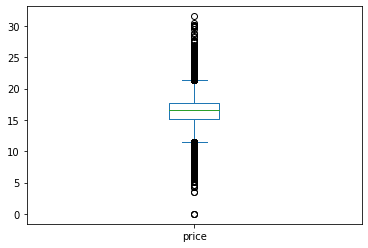

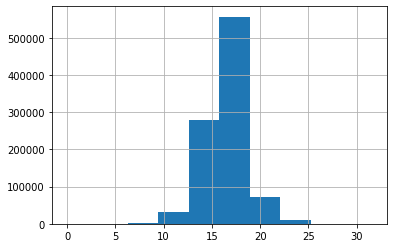

..:: Tipo de DF: Prueba ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 196 (100.0%)
Cantidad de registros con valor Cero en price: 0 (0.0%)


In [539]:
def exploracion_precio(df, tipo_df="entrenamiento", plot=True):
    print(f"..:: Tipo de DF: {tipo_df} ::..")
    print(f"Tipo de dato de columna price: {df.price.dtype}")

    nans_en_price_col = df.price.isna().sum()
    print(
        f"Cantidad de NaNs en col price: {nans_en_price_col} ({nans_en_price_col*100/len(df)}%)")

    cantidad_ceros_en_price_col = df.price[df.price == 0].count()
    print(
        f"Cantidad de registros con valor Cero en price: {cantidad_ceros_en_price_col} ({cantidad_ceros_en_price_col*100/len(df)}%)")

    if tipo_df == "entrenamiento" and plot:
        #np.log2(df.price).plot.box()
        #df.price[df.price.notna()].plot.box()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).plot.box()
        plt.show()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).hist()
        plt.show()


exploracion_precio(df_entrenamiento_crudo)
exploracion_precio(df_prueba_inicial, tipo_df="Prueba", plot=False)


Se observa que la columna `price` es de tipo real y que la misma contiene mas de 40 mil registros `NaNs` y casi 3 mil en cero para el dataset de entrenamiento. En el caso de pruebas, obviamente estos valores son todos NaNs.

Se analiza ademas la columna `currency`.

..:: Tipo de DF: entrenamiento ::..
object
44509 Cantidad de NaNs
2752  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 3080
Monedas NO peso ni dolar (%)= 0.308
Argentina         2735
Uruguay             14
Estados Unidos       3
Name: l1, dtype: int64


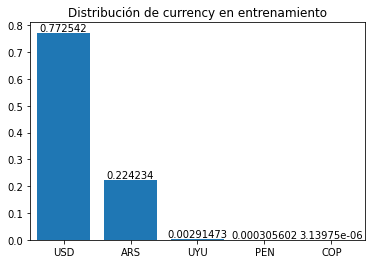

..:: Tipo de DF: Prueba ::..
object
0 Cantidad de NaNs
0  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 0
Monedas NO peso ni dolar (%)= 0.0
Series([], Name: l1, dtype: int64)


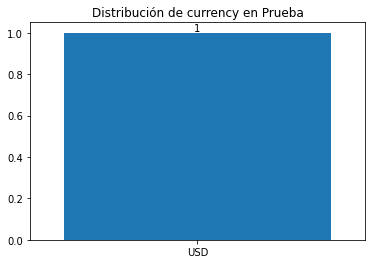

In [540]:
def analisis_columna_currency(df, tipo_df="entrenamiento"):
    print(f"..:: Tipo de DF: {tipo_df} ::..")

    print(df.currency.dtype)
    print(df.currency.isna().sum(), "Cantidad de NaNs")
    relative_freq_currency_table = df.currency.value_counts(
        normalize=True, )

    df[df.currency.isna(
    )]['price'].isna().sum() == df.price.isna().sum()
    #for currency_name, currency_rel_freq in df.currency.value_counts(normalize=True, ).items():
    #    df[df.currency == currency_name].value_counts()

    print(df[(df.currency.isna(
    )) & ~(df.price.isna())]["price"].count(), " currency en nan pero que tienen un precio")

    print('Monedas NO peso ni dolar=', df.currency.isin(['UYU', 'PEN', 'COP']).sum())
    print('Monedas NO peso ni dolar (%)=',
        df.currency.isin(['UYU', 'PEN', 'COP']).sum()*100 / len(df))
    
    print(df[(df.currency.isna()) & ~(df.price.isna())]["l1"].value_counts())
    
    ax = relative_freq_currency_table.plot.bar(rot=0, title=f"Distribución de currency en {tipo_df}")
    ax.bar_label(ax.bar(
        relative_freq_currency_table.index, relative_freq_currency_table.values.tolist()))
    plt.show()


analisis_columna_currency(df_entrenamiento_crudo)
analisis_columna_currency(df_prueba_inicial, tipo_df="Prueba")


Del análisis anterior para **entrenamiento**, se puede observar lo siguiente:

 * La mayoria de los registros estan o bien en pesos (~22%) o dolares (~77%).
   * El restante (menos del 0.4%) son otras monedas (cerca de 3 mil registros).
 * Existen ~41 mil registros que no tienen precio
   * Estos mismos coinciden con que no tienen tampoco la `currency`.
 * Existen 2752 que tienen `price` pero sin `currency`.
   * De estos, 2735 son de Argentina, 14 de Uruguay y 3 de USA (se podria imputar `ARS`, `UYU` y `USD` respectivamente).

Para **pruebas**, la cuestión se reduce a que estan presentes el tipo de currency (USD).

## Análisis de columnas de propiedades

A continuación, se analizan los tipos de propiedades presentes en el dataset, es decir, la columna `property_type`.

Venta                750831
Alquiler             207490
Alquiler temporal     41679
Name: operation_type, dtype: int64


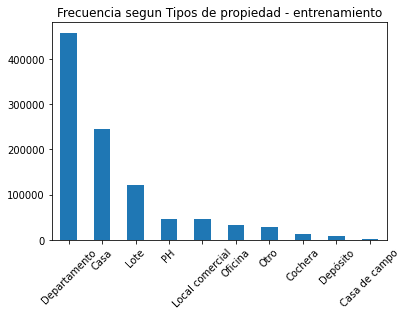

Venta    196
Name: operation_type, dtype: int64


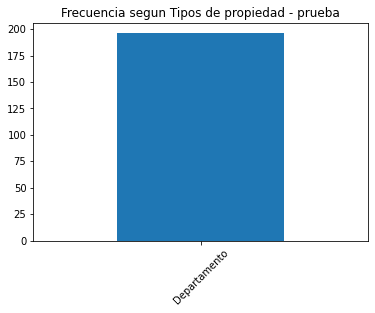

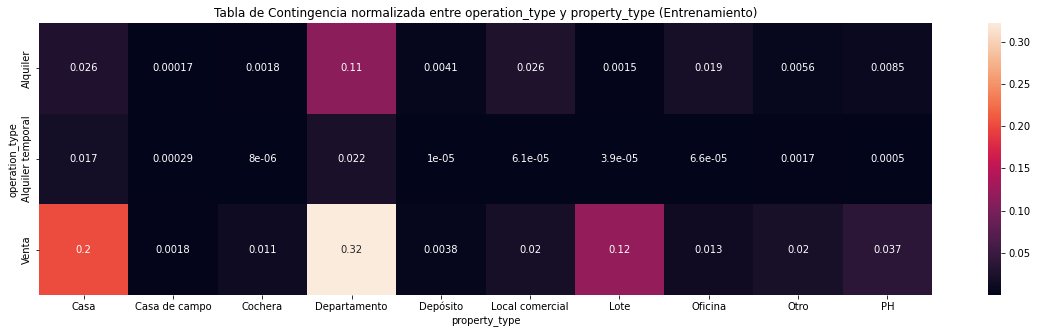

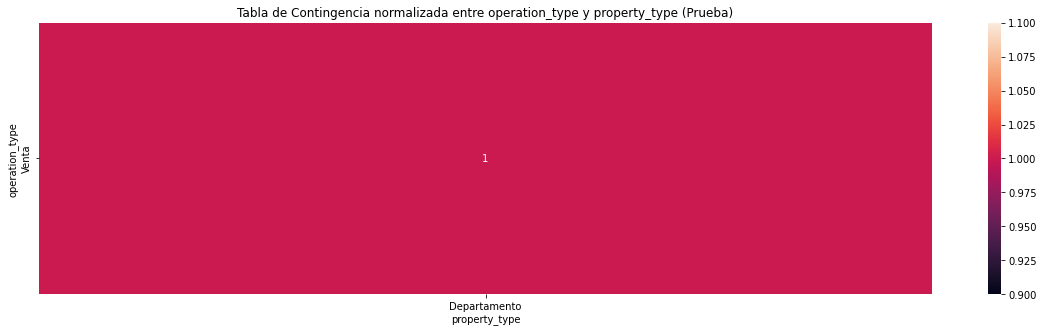

In [541]:
def analisis_operaciones_propiedades(df, tipo_df="entrenamiento"):
    print(df.operation_type.value_counts())
    _ = df.property_type.value_counts().plot.bar(
        rot=45, title=f"Frecuencia segun Tipos de propiedad - {tipo_df}")
    plt.show()

analisis_operaciones_propiedades(df_entrenamiento_crudo)
analisis_operaciones_propiedades(df_prueba_inicial, "prueba")

#df_entrenamiento_crudo.plot.scatter(x="operation_type", y="property_type")
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title(
    'Tabla de Contingencia normalizada entre operation_type y property_type (Entrenamiento)')
sns.heatmap(pd.crosstab(df_entrenamiento_crudo.operation_type,
            df_entrenamiento_crudo.property_type,  normalize=True), annot=True, ax=ax);


fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title(
    'Tabla de Contingencia normalizada entre operation_type y property_type (Prueba)')
sns.heatmap(pd.crosstab(df_prueba_inicial.operation_type,
            df_prueba_inicial.property_type,  normalize=True), annot=True, ax=ax);


Para el caso de entrenamiento:
- A partir de lo anterior, tenemos entonces una preminencia de propiedades de tipo Deptos, casas y lotes.
- Por el lado del tipo de operación, el tipo `Venta` representa prácticamente el 75% de las observaciones.

Para pruebas:
- Se observa que son solo operaciones de venta
- Lo unico presente en el dataset son Deptos

Analizamos la distribución por Pais:

In [542]:
print(df_entrenamiento_crudo.l1.value_counts())
print(df_prueba_inicial.l1.value_counts())


Argentina         983115
Uruguay            15749
Estados Unidos       892
Brasil               244
Name: l1, dtype: int64
Argentina    196
Name: l1, dtype: int64


Interesa particularmente ver cuantas publicaciones existen para Argentina, en dolares, en el df de entrenamiento:

In [543]:
print(df_entrenamiento_crudo.currency[df_entrenamiento_crudo.l1 == "Argentina"].value_counts())


USD    724879
ARS    214114
PEN       292
COP         3
Name: currency, dtype: int64


Observamos entonces que existen aprox un ~72% de publicaciones que son de Argentina en dolares.

¿Que hay respecto de las provincias entre entrenamiento y pruebas?

In [544]:
print(df_entrenamiento_crudo.l2.value_counts())
print(df_prueba_inicial.l2.value_counts())


Capital Federal                 265125
Bs.As. G.B.A. Zona Norte        184310
Bs.As. G.B.A. Zona Sur          131431
Santa Fe                         91565
Bs.As. G.B.A. Zona Oeste         76786
Buenos Aires Costa Atlántica     73759
Córdoba                          66274
Buenos Aires Interior            23975
Neuquén                          15487
Mendoza                           9172
Río Negro                         7935
Maldonado                         7784
Entre Ríos                        6750
Tucumán                           6531
Salta                             6056
Montevideo                        5909
Misiones                          4516
San Luis                          2654
Chaco                             1716
La Pampa                          1660
Corrientes                        1573
Chubut                            1529
San Juan                          1390
Colonia                           1213
Canelones                          720
Jujuy                    

se revisara l3 en pruebas

In [545]:
print(df_prueba_inicial.l3.value_counts())
print(df_prueba_inicial.l3.isna().sum())
df_prueba_inicial.shape


San Isidro       9
Vicente López    8
1 Ambiente       7
La Matanza       6
Moron            4
Ituzaingó        3
Tigre            1
Moreno           1
Name: l3, dtype: int64
157


(196, 22)

In [546]:
df_entrenamiento_crudo.property_type.value_counts()

Departamento       457907
Casa               245726
Lote               121311
PH                  45837
Local comercial     45593
Oficina             32390
Otro                27837
Cochera             13276
Depósito             7872
Casa de campo        2251
Name: property_type, dtype: int64

In [547]:
df_entrenamiento_crudo.l2.value_counts()


Capital Federal                 265125
Bs.As. G.B.A. Zona Norte        184310
Bs.As. G.B.A. Zona Sur          131431
Santa Fe                         91565
Bs.As. G.B.A. Zona Oeste         76786
Buenos Aires Costa Atlántica     73759
Córdoba                          66274
Buenos Aires Interior            23975
Neuquén                          15487
Mendoza                           9172
Río Negro                         7935
Maldonado                         7784
Entre Ríos                        6750
Tucumán                           6531
Salta                             6056
Montevideo                        5909
Misiones                          4516
San Luis                          2654
Chaco                             1716
La Pampa                          1660
Corrientes                        1573
Chubut                            1529
San Juan                          1390
Colonia                           1213
Canelones                          720
Jujuy                    

## Análisis de fechas

Existen 3 columnas de fechas: start_date, created_on y end_date.

In [548]:
for col in columnas_fecha:
    print(pd.to_datetime(df_entrenamiento_crudo[col], errors='coerce').dtype)


datetime64[ns]
datetime64[ns]
datetime64[ns]


En el caso de la columna end_date, existe una fecha mal ingresada '9999-...' que excede los límites del tipo de dato `datetime64[ns]`.

In [549]:
df_entrenamiento_crudo.end_date.value_counts()


9999-12-31    208960
2021-06-05     70852
2021-04-09     23315
2020-10-03     15205
2020-09-04     14608
               ...  
2021-06-20        83
2020-05-27        72
2020-06-07        66
2020-05-24        29
2020-08-22         1
Name: end_date, Length: 450, dtype: int64

En este caso, se le va a imputar el máximo valor del tipo de dato permitido.

## Generación de dataset limpio

Para organizar el código, acá se definen una serie de reglas de limpieza inicial, Que se guardaran para su uso en las etapas siguientes sin tener que re-ejecutar todo estos pasos nuevamente.

**Definiciones del dataset limpio inicial**

- Se conservan solo filas con currency en dolares.
- Se conservan filas que solo sean de Argentina
- Se conservan filas de Capital Federal y Buenos Aires (Zona Norte y Oeste)
- Se conservan solo las operaciones de venta.
- Se mantienen en el df aquellas propiedades de tipo Cochera.

Ademas, un conjunto de registros serán descartados en función de los siguientes criterios:

- Se eliminan registros con cero o NaN en `price`.

In [550]:
print("Registros originales", len(df_entrenamiento_crudo))
df_entrenamiento_limpio = df_entrenamiento_crudo[df_entrenamiento_crudo.currency == 'USD']
print("Registros luego de filtrar por publicaciones en dolares", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.l1 == 'Argentina']
print("Registros luego de filtrar por publicaciones de Argentina", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[(df_entrenamiento_limpio.l2 == 'Capital Federal') | (df_entrenamiento_limpio.l2 == 'Bs.As. G.B.A. Zona Norte') | (df_entrenamiento_limpio.l2 == 'Bs.As. G.B.A. Zona Oeste')]
print("Registros luego de filtrar por publicaciones de CABA y GBA Norte y Oeste", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.operation_type == 'Venta']
print("Registros luego de filtrar por publicaciones de tipo Venta", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.property_type.isin(['Cochera'])]
print("Registros luego de filtrar por publicaciones de inmuebles Cocheras", len(df_entrenamiento_limpio))
#df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.price.notna()]
#print("Registros luego de filtrar por publicaciones con precio en nulo", len(df_entrenamiento_limpio))
#df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.price != 0]
#print("Registros luego de filtrar por publicaciones con precio en cero", len(df_entrenamiento_limpio))
#

Registros originales 1000000
Registros luego de filtrar por publicaciones en dolares 738157
Registros luego de filtrar por publicaciones de Argentina 724879
Registros luego de filtrar por publicaciones de CABA y GBA Norte y Oeste 405180
Registros luego de filtrar por publicaciones de tipo Venta 371783
Registros luego de filtrar por publicaciones de inmuebles Cocheras 6394


Se van a crear campos de tipo datetime, y en el caso de end_date, se imputará el valor máximo del tipo de dato.

In [551]:
pd.Timestamp.max


Timestamp('2262-04-11 23:47:16.854775807')

In [552]:
#pd.Timestamp.max
for columna in columnas_fecha:
    df_entrenamiento_limpio[columna] = pd.to_datetime(
        df_entrenamiento_crudo[columna], errors='coerce').fillna(pd.to_datetime(pd.Timestamp.max))

print(df_entrenamiento_limpio[columnas_fecha].dtypes)
df_entrenamiento_limpio.end_date.value_counts()

start_date    datetime64[ns]
end_date      datetime64[ns]
created_on    datetime64[ns]
dtype: object


2262-04-11 23:47:16.854775807    1256
2021-06-05 00:00:00.000000000     351
2021-04-15 00:00:00.000000000     183
2021-04-16 00:00:00.000000000     154
2021-04-22 00:00:00.000000000     150
                                 ... 
2020-09-21 00:00:00.000000000       1
2021-08-07 00:00:00.000000000       1
2021-07-18 00:00:00.000000000       1
2020-07-17 00:00:00.000000000       1
2020-12-13 00:00:00.000000000       1
Name: end_date, Length: 367, dtype: int64

Se guarda el dataset para que se parta de este de ahora en adelante.

In [553]:
df_entrenamiento_limpio.to_csv(archivo_limpieza_inicial, index=False)


# Análisis del conjunto de datos

Se analizan ambos datasets para conocerlos y caracterizarlos, ahora que el dataset de entrenamiento se encuentra limpio de registros que no tienen nada que ver con la tarea de predicción a realizar.

In [554]:
df_entrenamiento_inicial = pd.read_csv(
    archivo_limpieza_inicial, parse_dates=columnas_fecha)
df_prueba_inicial = pd.read_csv(
    archivo_prueba, parse_dates=columnas_fecha)
    

In [555]:
#df_prueba_inicial.dtypes
#df_prueba_inicial.shape
#df_prueba_inicial.end_date.value_counts()

## Estudio de dataset de prueba

Se analiza este dataset en mayor profundidad que la sección anterior a fin de determinar cual es la población a predecir. Esto definira algunas estrategias de limpieza de datos.

### Análisis del dataset segun barrios

In [556]:
print(df_prueba_inicial.l3.value_counts())
print(df_prueba_inicial.l3.value_counts().sum())
df_prueba_inicial.l3.shape


San Isidro       9
Vicente López    8
1 Ambiente       7
La Matanza       6
Moron            4
Ituzaingó        3
Tigre            1
Moreno           1
Name: l3, dtype: int64
39


(196,)

Solo 39 campos figuran como barrio, y son en realidad localidades de GBA. La columna l3 no sirve demasiado

### Estudio de características de la propiedad

Nos referimos acá a las columnas que nos indican propiedades el inmueble en sí.

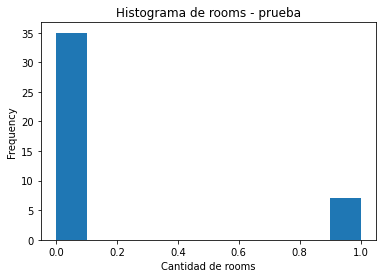

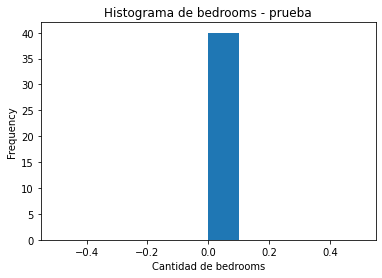

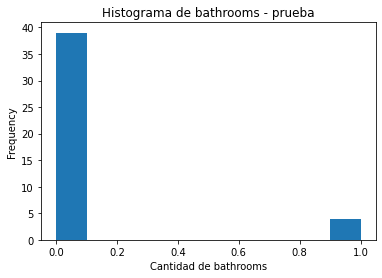

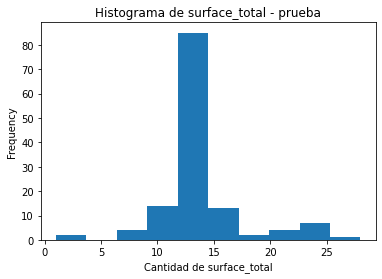

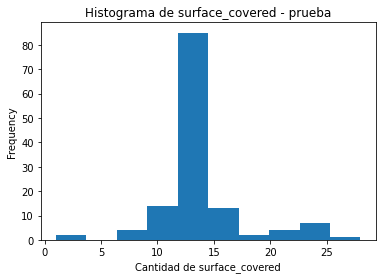

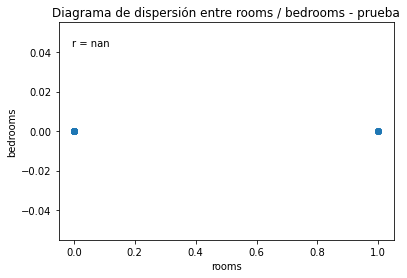

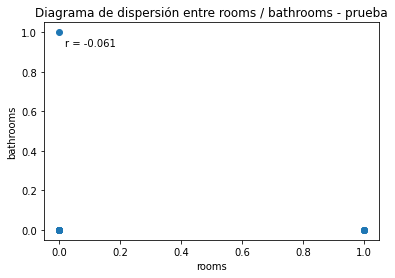

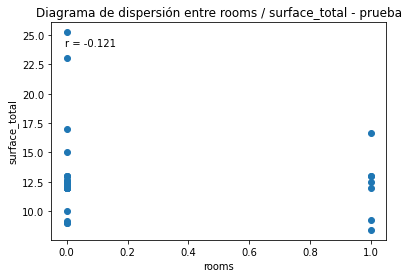

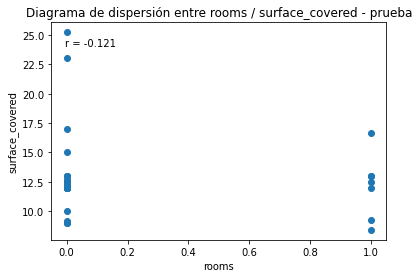

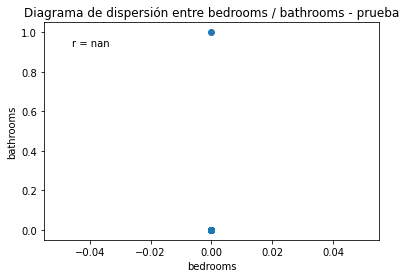

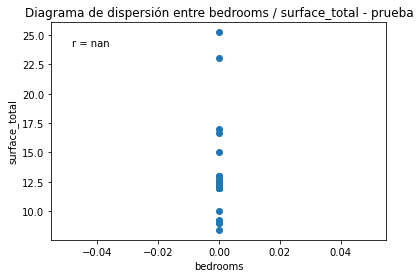

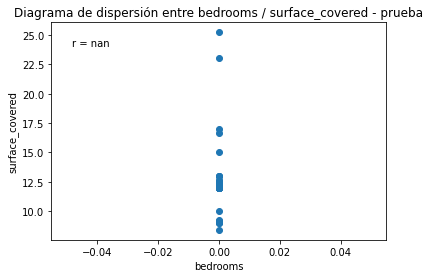

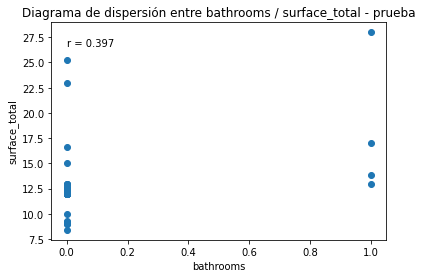

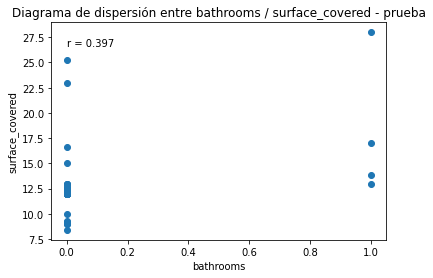

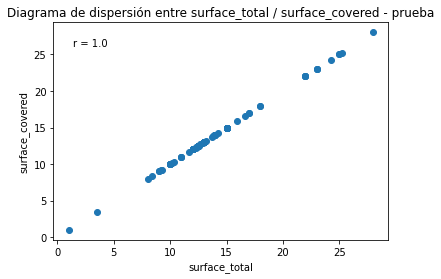

In [557]:
graficar_histogramas(df_prueba_inicial, columnas_de_propiedad, "prueba")
graficar_scatters(df_prueba_inicial, columnas_de_propiedad, "prueba")


## Estudio de dataset de entrenamiento


### Columna de precios

In [558]:
df_entrenamiento_inicial.price.isna().sum()


0

### Estudio de Columnas de propiedad

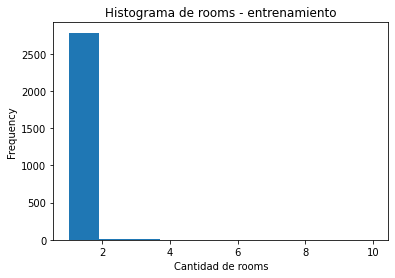

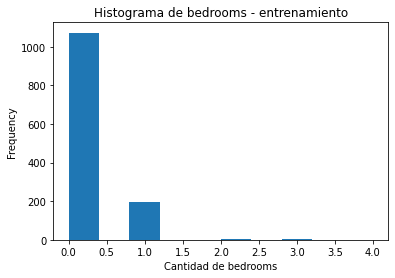

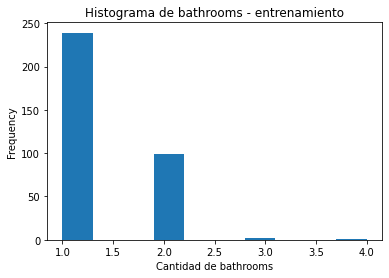

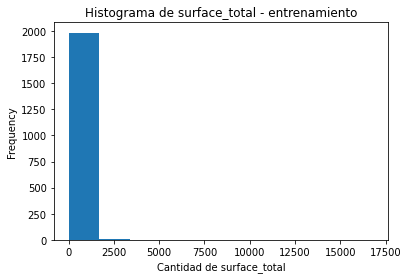

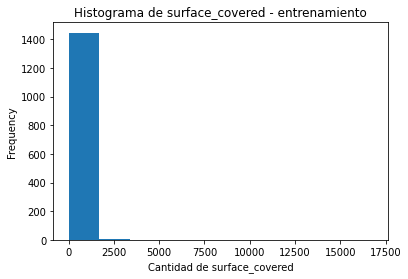

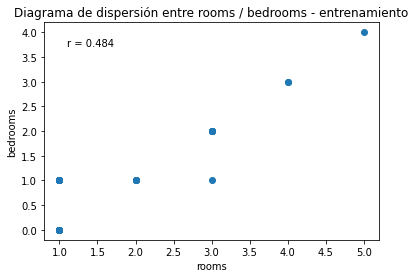

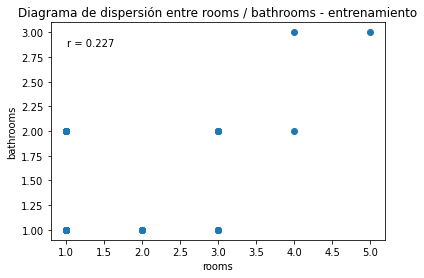

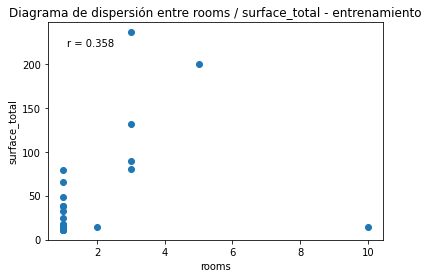

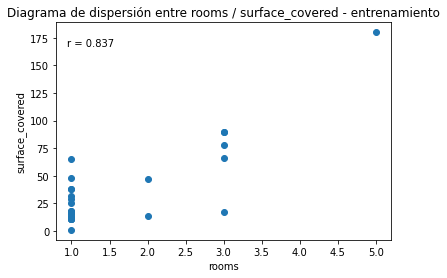

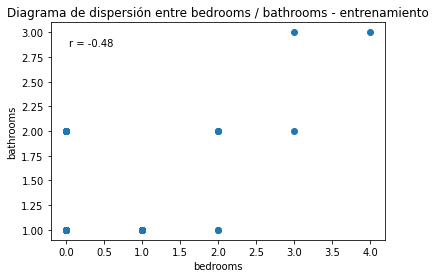

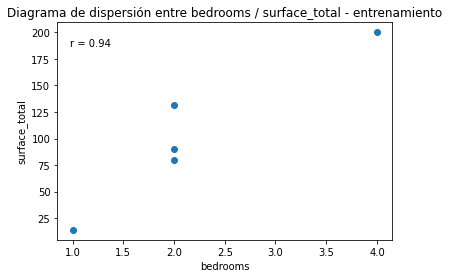

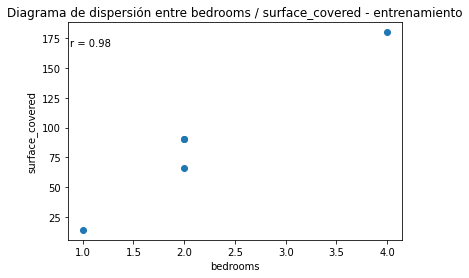

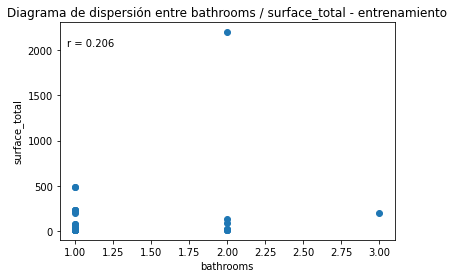

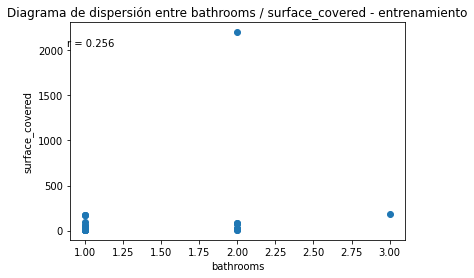

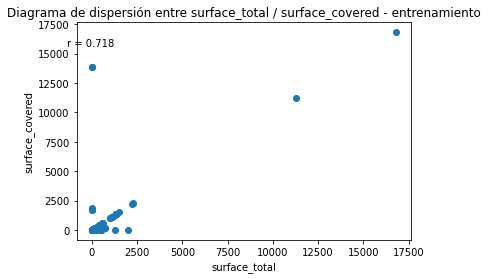

In [559]:
graficar_histogramas(df_entrenamiento_inicial, columnas_de_propiedad)
graficar_scatters(df_entrenamiento_inicial, columnas_de_propiedad)


### Estudio de columnas de fechas

A continuación se estudian los valores relacionados a las columnas de fechas

In [560]:
df_entrenamiento_inicial[columnas_fecha].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6394 entries, 0 to 6393
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  6394 non-null   datetime64[ns]
 1   end_date    6394 non-null   datetime64[ns]
 2   created_on  6394 non-null   datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 150.0 KB


In [561]:
df_entrenamiento_inicial[columnas_fecha].head()


,start_date,end_date,created_on
0,2020-08-22,2020-09-04,2020-08-22
1,2021-03-21,2021-03-26,2021-03-21
2,2020-06-09,2020-10-22,2020-06-09
3,2020-06-09,2021-04-09,2020-06-09
4,2020-06-09,2021-04-09,2020-06-09


In [562]:
df_entrenamiento_inicial[columnas_fecha].describe(datetime_is_numeric=True)


,start_date,end_date,created_on
count,6394,6394,6394
mean,2020-12-30 19:11:03.246793728,2068-06-29 14:07:13.389051392,2020-12-30 19:11:03.246793728
min,2020-05-24 00:00:00,2020-05-29 00:00:00,2020-05-24 00:00:00
25%,2020-09-26 00:00:00,2020-12-22 00:00:00,2020-09-26 00:00:00
50%,2021-01-12 00:00:00,2021-04-21 00:00:00,2021-01-12 00:00:00
75%,2021-04-20 00:00:00,2021-06-08 00:00:00,2021-04-20 00:00:00
max,2021-06-17 00:00:00,2262-04-11 23:47:16.854775807,2021-06-17 00:00:00


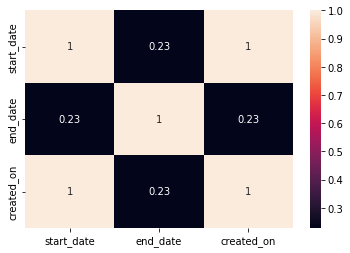

In [563]:
#print(df_entrenamiento_inicial[columnas_fecha].corr(method="pearson"))
#df_entrenamiento_inicial.start_date.corr(df_entrenamiento_inicial.end_date, method="pearson")
#df_entrenamiento_inicial[columnas_fecha].apply(lambda x: x.factorize()[0]).corr()
graficar_correlograma(df_entrenamiento_inicial[columnas_fecha].apply(
    lambda x: x.factorize()[0]), columnas_fecha)


Se observa claramente que `start_date` y `created_on` son la misma columna.

In [564]:
assert (df_entrenamiento_inicial.start_date ==
        df_entrenamiento_inicial.created_on).sum() == len(df_entrenamiento_inicial), \
    "El ds de entrenamiento tiene diferencias entre columnas start_date y created_on"


¿Que pasa con cada columna individual?

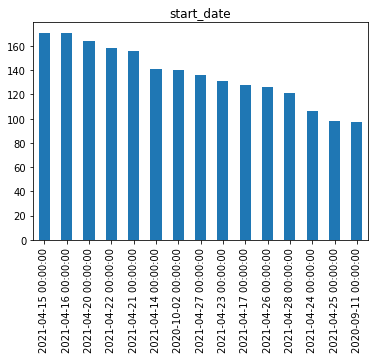

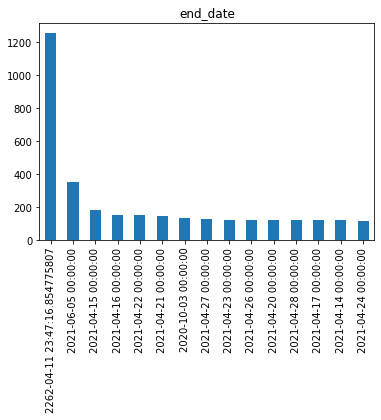

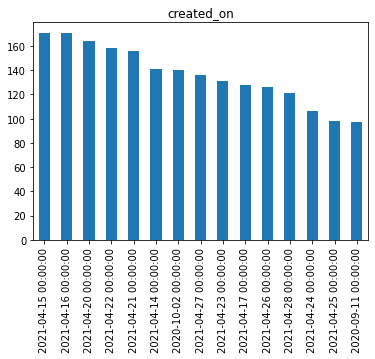

In [565]:
for columna in columnas_fecha:
    df_entrenamiento_inicial[columna].value_counts()[:15].plot(kind='bar')
    plt.title(columna)
    plt.show()


La columna `end_date` se usa bastante mal. El valor con mayor frecuencia es `9999-12-31` (reemplazado por el máximo, pero sigue siendo anomalo). El mismo aparece mas del 20 % de las veces.

### Estudio de columnas de publicación

Las columnas de publicación son aquellas que refieren a información de la propiedad publicada.

In [566]:
df_entrenamiento_inicial[columnas_publicacion].describe(include=object)

,currency,price_period,title,description,property_type,operation_type
count,6394,3392,6394,6394,6394,6394
unique,1,1,2912,4224,1,1
top,USD,Mensual,"Cochera en Venta en Belgrano, Capital federal ...","Las medidas, superficies y montos de expensas ...",Cochera,Venta
freq,6394,3392,233,57,6394,6394


In [567]:
df_entrenamiento_inicial[columnas_publicacion].describe()


,price
count,6.394000e+03
mean,3.362445e+04
std,1.224156e+05
min,4.800000e+03
25%,1.700000e+04
50%,2.250000e+04
75%,2.700000e+04
max,4.000000e+06


In [568]:
columnas_publicacion_sin_precio = list(columnas_publicacion)
columnas_publicacion_sin_precio.remove('price')


<AxesSubplot:>

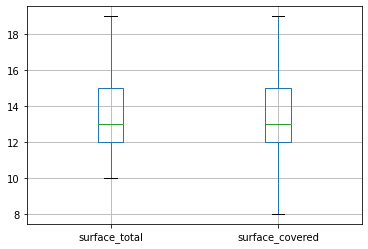

In [569]:
df_entrenamiento_inicial[['surface_total', 'surface_covered']].boxplot(
    showfliers=False)


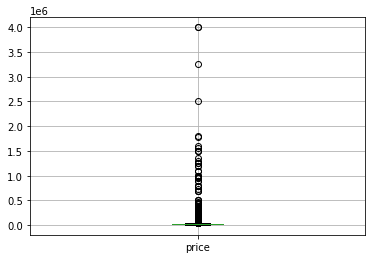

In [570]:
df_entrenamiento_inicial[['price']].boxplot();


En cuanto a los NaNs presentes en estas columnas, se puede observar lo siguiente:

In [571]:
#print("Colname - % de nulls")
#df_entrenamiento_inicial[columnas_publicacion].isna(
#).sum() / len(df_entrenamiento_inicial)

#print("Colname - % de nulls")
prop_nans_por_columna = df_entrenamiento_inicial.isna(
).sum() / len(df_entrenamiento_inicial)
columnas_con_nans_a_descartar = list(
    prop_nans_por_columna[prop_nans_por_columna > 0.65].index)
columnas_con_nans_a_descartar


['bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

## Varianza de las columnas

se eliminan las columnas cuyos valores son identicos en todos los registros

In [572]:
columnas_con_varianza_cero = []

for column in df_entrenamiento_inicial.columns:
  if (df_entrenamiento_inicial[column] == df_entrenamiento_inicial[column][0]).all():
    columnas_con_varianza_cero.append(column)
    print(f"\nLa col {column} tiene varianza cero")
    print(df_entrenamiento_inicial[column].value_counts())
columnas_con_varianza_cero



La col ad_type tiene varianza cero
Propiedad    6394
Name: ad_type, dtype: int64

La col l1 tiene varianza cero
Argentina    6394
Name: l1, dtype: int64

La col currency tiene varianza cero
USD    6394
Name: currency, dtype: int64

La col property_type tiene varianza cero
Cochera    6394
Name: property_type, dtype: int64

La col operation_type tiene varianza cero
Venta    6394
Name: operation_type, dtype: int64


['ad_type', 'l1', 'currency', 'property_type', 'operation_type']

## Otras columnas a descartar

- Se descarta `created_on` por ser identica a `start_date`

In [573]:
columnas_a_descartar = [
    'created_on',
    'l3',
]

# Tratamiento de los datos


In [574]:
df_entrenamiento_nuevas_columnas = df_entrenamiento_inicial
df_prueba = df_prueba_inicial.copy()


## Creación de nuevas columnas

### Columnas derivadas de fechas

Columnas que se crean a partir de las fechas:

- duracion_publicacion: tiempo que la publicación esta en linea, en cantidad de dias. Resta end_date menos start_date. Si end_date es mayor a fecha de hoy, se queda con fecha de hoy.

In [575]:
#from datetime import date
#pd.to_datetime(date.today())
#max(df_entrenamiento_limpio.end_date)
#min(max(df_entrenamiento_limpio.end_date), pd.to_datetime(date.today()))


In [576]:
#np.where(df_entrenamiento_inicial.end_date ==
#         pd.Timestamp.max, pd.to_datetime(date.today()), df_entrenamiento_inicial.end_date)
#df_entrenamiento_inicial.end_date[df_entrenamiento_inicial.end_date == pd.Timestamp.max]
#col_end = df_entrenamiento_inicial.end_date.copy()
#col_end.replace({pd.Timestamp.max: pd.to_datetime(date.today())}, inplace=True)
#col_end - df_entrenamiento_inicial.start_date


In [577]:
def crear_columna_duracion(df, columna_inicio="start_date", columna_fin="end_date"):
    hoy = pd.to_datetime(date.today())
    columna_fin = df[columna_fin].copy()
    columna_fin.replace({pd.Timestamp.max: pd.to_datetime(date.today())}, inplace=True)
    #duracion_publicacion = (columna_fin - df[columna_inicio]).dt.days
    duracion_publicacion = columna_fin - df[columna_inicio]
    return duracion_publicacion.dt.days


df_entrenamiento_nuevas_columnas["duracion_publicacion"] = crear_columna_duracion(
    df_entrenamiento_nuevas_columnas)
df_prueba["duracion_publicacion"] = crear_columna_duracion(df_prueba)


### Columnas derivadas de localidades

- encoding de localidades
- desvio del m2 promedio de localidades (cubiertos y totales)

In [578]:
localidades = df_entrenamiento_nuevas_columnas.l2.value_counts().index.to_list()

In [579]:
label_encoder = LabelEncoder()
label_encoder.fit(localidades)
df_entrenamiento_nuevas_columnas["localidades_encoded"] = label_encoder.transform(df_entrenamiento_nuevas_columnas.l2)
df_prueba["localidades_encoded"] = label_encoder.transform(df_prueba.l2)


Armamos la siguiente métrica con la mediana porque aun no se hizo un analisis de outliers

In [580]:
#print(df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l2)["surface_total"].mean())
#df_entrenamiento_nuevas_columnas.surface_covered - mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l2]
#df_entrenamiento_nuevas_columnas.surface_covered - \
#    mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l2]
mediana_surface_covered_por_barrio = df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l2)["surface_covered"].mean()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_cubiertos"] = abs(df_entrenamiento_nuevas_columnas.surface_covered - \
    df_entrenamiento_nuevas_columnas.l2.map(mediana_surface_covered_por_barrio))
df_prueba["distancia_mediana_m2_cubiertos"] = abs(df_prueba.surface_covered - \
    df_prueba.l2.map(mediana_surface_covered_por_barrio))


In [581]:
mediana_surface_total_por_barrio = df_entrenamiento_nuevas_columnas.groupby(
    df_entrenamiento_nuevas_columnas.l2)["surface_total"].mean()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_totales"] = abs(df_entrenamiento_nuevas_columnas.surface_total - \
    df_entrenamiento_nuevas_columnas.l2.map(mediana_surface_total_por_barrio))
df_prueba["distancia_mediana_m2_totales"] = abs(df_prueba.surface_total - \
    df_prueba.l2.map(mediana_surface_total_por_barrio))


### Columnas derivadas de texto

* Palabras importantes presentes en titulo

In [582]:
# todo a minuscula
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title'].str.lower()
df_prueba['title_tokenized'] = df_prueba['title'].str.lower()

# tokenizacion
regexp = RegexpTokenizer('\w+')
df_entrenamiento_nuevas_columnas["title_tokenized"] = df_entrenamiento_nuevas_columnas["title_tokenized"].apply(regexp.tokenize)
df_prueba["title_tokenized"] = df_prueba["title_tokenized"].apply(regexp.tokenize)

# normalizacion por ahora no

# tratamiento de palabras vacias
stopwords = nltk.corpus.stopwords.words("spanish")
#stopwords.extend(['es', 'osea', 'sólo'])
stopwords.extend(['c'])
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])
df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])


In [583]:
stemmer = SnowballStemmer('spanish')
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])
df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])


In [584]:
df_entrenamiento_nuevas_columnas['title_limpio'] = df_entrenamiento_nuevas_columnas['title_tokenized'].str.join(' ')
df_prueba['title_limpio'] = df_prueba['title_tokenized'].str.join(' ')


In [585]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(
    1, 3), min_df=0.005, max_df=0.9, strip_accents='ascii', max_features=3000)
vectorizer = vectorizer.fit(
    df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_training = vectorizer.transform(df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_testing = vectorizer.transform(df_prueba['title_limpio'])
count_df_training = pd.DataFrame(vectorized_data_training.toarray(), columns=vectorizer.get_feature_names_out())
count_df_testing = pd.DataFrame(vectorized_data_testing.toarray(), columns=vectorizer.get_feature_names_out())


In [586]:
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"] = count_df_training.sum(axis=1) / len(count_df_training.columns)
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"]


0       0.026936
1       0.000000
2       0.037037
3       0.020202
4       0.016835
          ...   
6389    0.033670
6390    0.013468
6391    0.013468
6392    0.006734
6393    0.020202
Name: cantidad_palabras_importantes_titulo, Length: 6394, dtype: float64

In [587]:
df_prueba["cantidad_palabras_importantes_titulo"] = count_df_testing.sum(axis=1) / len(count_df_testing.columns)
df_prueba["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_prueba["cantidad_palabras_importantes_titulo"]

0      0.043771
1      0.013468
2      0.013468
3      0.026936
4      0.037037
         ...   
191    0.020202
192    0.016835
193    0.023569
194    0.016835
195    0.030303
Name: cantidad_palabras_importantes_titulo, Length: 196, dtype: float64

Algunas columnas derivadas de texto puntual en la publicación

In [588]:
#df_entrenamiento_nuevas_columnas['title_limpio'].to_csv('.data/prueba.csv')
count_df_training.sum(axis=0).nlargest(n=30)


vent                       3977
cocher vent                2844
capital                    1712
capital federal            1711
federal                    1711
belgran                    1414
vent belgran               1203
cocher vent belgran        1195
belgran capital            1180
belgran capital federal    1180
vent belgran capital       1173
vent cocher                 750
cubiert                     668
fij                         625
000                         624
cocher fij                  549
san                         473
vill                        457
oportun                     387
cocher cubiert              353
excelent                    338
palerm                      319
fij cubiert                 278
000 cocher                  268
000 cocher vent             261
cocher fij cubiert          258
25000                       251
capital federal 25000       248
federal 25000               248
recolet                     243
dtype: int64

In [589]:
df_entrenamiento_nuevas_columnas["title_tiene_venta"] = df_entrenamiento_nuevas_columnas["title_limpio"].map(lambda x: 1 if "vent" in x else 0)
df_entrenamiento_nuevas_columnas["title_tiene_cochera"] = df_entrenamiento_nuevas_columnas["title_limpio"].map(lambda x: 1 if "cocher" in x else 0)
df_entrenamiento_nuevas_columnas["title_tiene_oportunidad"] = df_entrenamiento_nuevas_columnas["title_limpio"].map(lambda x: 1 if "oportun" in x else 0)
df_entrenamiento_nuevas_columnas["title_tiene_excelent"] = df_entrenamiento_nuevas_columnas["title_limpio"].map(lambda x: 1 if "excelent" in x else 0)

df_prueba["title_tiene_venta"] = df_prueba["title_limpio"].map(lambda x: 1 if "vent" in x else 0)
df_prueba["title_tiene_cochera"] = df_prueba["title_limpio"].map(lambda x: 1 if "cocher" in x else 0)
df_prueba["title_tiene_oportunidad"] = df_prueba["title_limpio"].map(lambda x: 1 if "oportun" in x else 0)
df_prueba["title_tiene_excelent"] = df_prueba["title_limpio"].map(lambda x: 1 if "excelent" in x else 0)

## Selección de columnas finales


In [590]:
columnas_finales = set(df_entrenamiento_nuevas_columnas.select_dtypes(include=np.number).columns) - \
    set(columnas_con_nans_a_descartar) - \
    set(columnas_con_varianza_cero) - \
    set(columnas_a_descartar)
columnas_finales = list(columnas_finales)
columnas_finales


['distancia_mediana_m2_totales',
 'title_tiene_cochera',
 'title_tiene_venta',
 'distancia_mediana_m2_cubiertos',
 'rooms',
 'lat',
 'lon',
 'localidades_encoded',
 'title_tiene_oportunidad',
 'cantidad_palabras_importantes_titulo',
 'title_tiene_excelent',
 'duracion_publicacion',
 'price']

In [591]:
df_entrenamiento = df_entrenamiento_nuevas_columnas[columnas_finales]
df_prueba = df_prueba[columnas_finales]


## Outliers

Detectar outliers en base al rango intercuartilico


In [592]:
# Outliers analisis
#df_entrenamiento_inicial[(np.abs(stats.zscore(df_entrenamiento_inicial)) < 3).all(axis=1)]
#np.abs(stats.zscore(df_entrenamiento_inicial)) > 3

def outliers(df, lt, umbral=1.5):
    Q1 = df[lt].quantile(0.25)
    Q3 = df[lt].quantile(0.75)
    IQR = Q3 - Q1
    corte_inferior = Q1 - umbral * IQR
    corte_superior = Q3 + umbral * IQR

    # armo una lista de indices con outliers
    lista = df.index[(df[lt] < corte_inferior) | (df[lt] > corte_superior)]

    return lista

lista_outliers = {}
conjunto_outliers = set([])

# la columna precio no fue incluida
for col in df_entrenamiento.columns.drop('price'):
  lista_outliers[col] = outliers(df_entrenamiento, col)
  conjunto_outliers.update(lista_outliers[col])

print(len(df_entrenamiento))
print(len(lista_outliers))
print(len(conjunto_outliers))

6394
12
2614


In [593]:
BORRAR_OUTLIERS=True

if BORRAR_OUTLIERS:
    df_entrenamiento = df_entrenamiento.drop(df_entrenamiento.index[list(conjunto_outliers)]).reset_index(drop=True)
print(len(df_entrenamiento))


3780


## Imputaciones

Varias imputaciones serán realizadas:

- Imputación manual de datos incorrectos
- Simple Imputer para NaNs

previo a esto, las columnas con mas de un 60% de NaNs se eliminaran

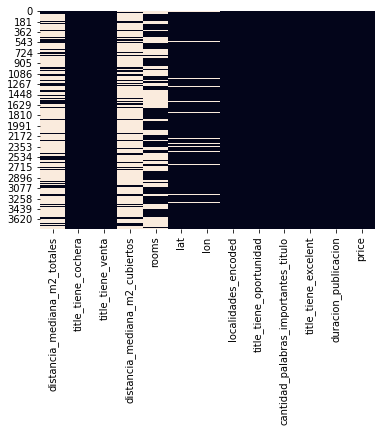

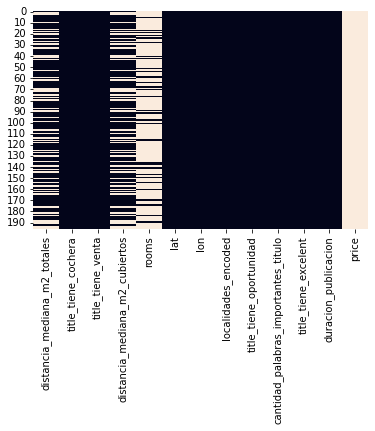

In [594]:
sns.heatmap(df_entrenamiento.isnull(), cbar=False);
plt.show()
sns.heatmap(df_prueba.isnull(), cbar=False);
plt.show()


Se prueba diversos métodos de imputación en referencia a que las columnas tienen muchos datos faltantes.

In [595]:
IMPUTAR = True
df_imputado = df_entrenamiento.copy()

if IMPUTAR:

    imp = SimpleImputer(strategy='median')
    # strategy == mean, median, most_frequent, constant

    imp.fit(df_imputado[df_imputado.columns.drop('price')])
    df_imputado[df_imputado.columns.drop('price')] = imp.transform(df_imputado[df_imputado.columns.drop('price')])
    df_prueba[df_imputado.columns.drop('price')] = imp.transform(df_prueba[df_imputado.columns.drop('price')])

    print(df_imputado.isna().sum() / len(df_imputado))
    print(df_prueba.isna().sum() / len(df_prueba))



distancia_mediana_m2_totales            0.0
title_tiene_cochera                     0.0
title_tiene_venta                       0.0
distancia_mediana_m2_cubiertos          0.0
rooms                                   0.0
lat                                     0.0
lon                                     0.0
localidades_encoded                     0.0
title_tiene_oportunidad                 0.0
cantidad_palabras_importantes_titulo    0.0
title_tiene_excelent                    0.0
duracion_publicacion                    0.0
price                                   0.0
dtype: float64
distancia_mediana_m2_totales            0.0
title_tiene_cochera                     0.0
title_tiene_venta                       0.0
distancia_mediana_m2_cubiertos          0.0
rooms                                   0.0
lat                                     0.0
lon                                     0.0
localidades_encoded                     0.0
title_tiene_oportunidad                 0.0
cantidad_palabras

In [596]:
DROPNA = False
if DROPNA:
    df_imputado = df_imputado.dropna()


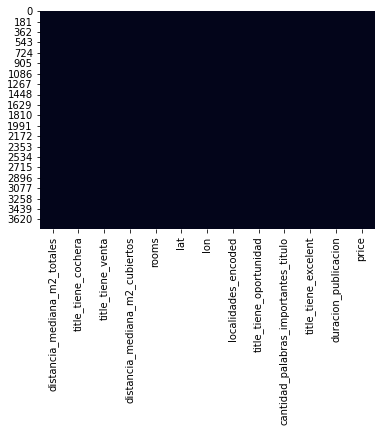

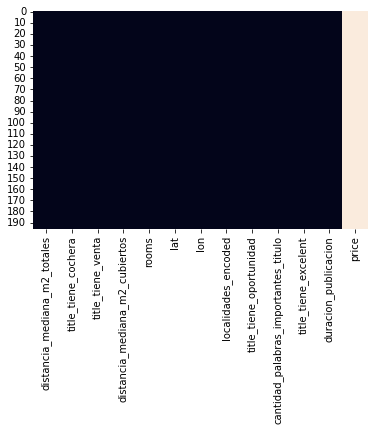

In [597]:
sns.heatmap(df_imputado.isnull(), cbar=False);
plt.show()
sns.heatmap(df_prueba.isnull(), cbar=False)
plt.show()


In [598]:
columnas_mismo_valor = []

for column in df_imputado.columns:
  if (df_imputado[column] == df_imputado[column][0]).all():
    columnas_mismo_valor.append(column)
    print(f"\nLa col {column} tiene varianza cero")
    print(df_imputado[column].value_counts())
columnas_mismo_valor



La col title_tiene_cochera tiene varianza cero
1.0    3780
Name: title_tiene_cochera, dtype: int64

La col rooms tiene varianza cero
1.0    3780
Name: rooms, dtype: int64

La col localidades_encoded tiene varianza cero
2.0    3780
Name: localidades_encoded, dtype: int64

La col title_tiene_oportunidad tiene varianza cero
0.0    3780
Name: title_tiene_oportunidad, dtype: int64

La col title_tiene_excelent tiene varianza cero
0.0    3780
Name: title_tiene_excelent, dtype: int64


['title_tiene_cochera',
 'rooms',
 'localidades_encoded',
 'title_tiene_oportunidad',
 'title_tiene_excelent']

In [599]:
df_imputado = df_imputado[df_imputado.columns.drop(columnas_mismo_valor)]
df_prueba = df_prueba[df_prueba.columns.drop(columnas_mismo_valor)]


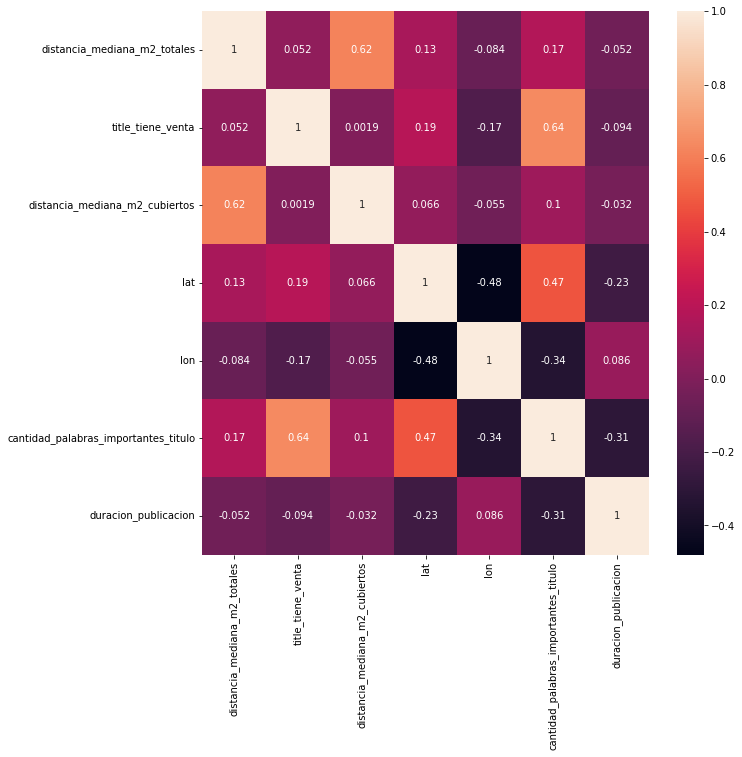

In [619]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_imputado[df_imputado.columns.drop(
    'price')].corr(), annot=True, ax=ax);


In [ ]:
# reemplazar esto por un algoritmo
#columnas_con_alta_correlacion = ['bedrooms', 'lat', 'surface_total']
#df_imputado = df_imputado[df_imputado.columns.drop(
#    columnas_con_alta_correlacion)]


In [505]:
df_prueba.isna().sum()

distancia_mediana_m2_totales              0
title_tiene_cochera                       0
title_tiene_venta                         0
distancia_mediana_m2_cubiertos            0
rooms                                     0
lat                                       0
lon                                       0
localidades_encoded                       0
title_tiene_oportunidad                   0
cantidad_palabras_importantes_titulo      0
title_tiene_excelent                      0
duracion_publicacion                      0
price                                   196
dtype: int64

## Estandarización y Normalización de Datos númericos


In [624]:
NORMALIZAR=False

dfe_estandarizado = df_imputado.select_dtypes(
    include=['float64', 'int64', 'uint8'])

if NORMALIZAR:
    # ESTO NO SE SI ANDA
    #df_entrenamiento_inicial.lat.hist(bins=50)

    features = dfe_estandarizado.columns.drop('price')

    # estandarización min-max
    dfe_estandarizado[features] = (dfe_estandarizado[features] -
                        dfe_estandarizado[features].min()) / (dfe_estandarizado[features].max() - dfe_estandarizado[features].min())

    dfe_transformado = pd.DataFrame([])
    dfe_transformado[features] = np.sqrt(dfe_estandarizado[features])
    dfe_transformado["price"] = dfe_estandarizado["price"]

    #dfe_estandarizado = dfe_estandarizado
    #dfe_transformado.lat.hist(bins=50);
else:
    dfe_transformado = dfe_estandarizado


In [625]:
#df_entrenamiento_inicial.lat.describe()
dfe_transformado.head()


,distancia_mediana_m2_totales,title_tiene_venta,distancia_mediana_m2_cubiertos,lat,lon,cantidad_palabras_importantes_titulo,duracion_publicacion,price
0,55.654599,0.0,72.356608,-34.610280,-58.382106,0.000000,5.0,25000.0
1,56.654599,1.0,73.356608,-34.576355,-58.448713,0.037037,135.0,26000.0
2,56.654599,1.0,73.356608,-34.629639,-58.460430,0.020202,304.0,22000.0
3,56.654599,1.0,73.356608,-34.629639,-58.460430,0.016835,304.0,28000.0
4,53.654599,0.0,73.356608,-34.579632,-58.448468,0.026936,7.0,33000.0


## Eliminación de columnas con baja varianza


In [601]:
df2 = dfe_transformado.select_dtypes(
    include=['float64', 'int64', 'uint8'])

varianzas_cols = {}
for c in df2.columns:
    varianzas_cols[c] = df2[c].var()

varianzas_ordenadas = dict(sorted(varianzas_cols.items(
), key=lambda item: item[1]), sort_keys=True, indent=4)
columnas_con_baja_varianza = []
for col, varianza in varianzas_ordenadas.items():
    print(col, varianza)
    if varianza == 0:
        columnas_con_baja_varianza.append(col)

print(columnas_con_baja_varianza)


cantidad_palabras_importantes_titulo 0.0002619300369161286
lat 0.0017625687508073045
lon 0.005798750585843457
rooms 0.023736863038490107
title_tiene_cochera 0.03045227906793779
title_tiene_excelent 0.04979562755850855
title_tiene_oportunidad 0.05687105182929738
title_tiene_venta 0.23519351127956506
localidades_encoded 0.43599835819019483
duracion_publicacion 40584.75083432326
distancia_mediana_m2_totales 77965.77871658506
distancia_mediana_m2_cubiertos 127036.839670415
price 14985570019.159967
sort_keys True
indent 4
[]


# Modelización

A continuación se define la selección de columnas a ser utilizadas

In [626]:
#columnas_a_modelar = set(df_entrenamiento_inicial.columns) - \
#    set(columnas_con_baja_varianza) - \
#    set(columnas_con_nans_a_descartar)
#columnas_a_modelar = list(columnas_a_modelar)
#columnas_a_modelar

print(dfe_transformado.isna().sum() / len(dfe_transformado))
#columnas_seleccionadas = dfe_transformado.columns.drop(['l6', 'l5'])

distancia_mediana_m2_totales            0.0
title_tiene_venta                       0.0
distancia_mediana_m2_cubiertos          0.0
lat                                     0.0
lon                                     0.0
cantidad_palabras_importantes_titulo    0.0
duracion_publicacion                    0.0
price                                   0.0
dtype: float64


## Selección de modelo

In [627]:
#df_entrenamiento_a_modelar = df_entrenamiento_inicial.select_dtypes(include=[
#                                                                    'float64', 'int64'])
df_entrenamiento_a_modelar = dfe_transformado
#df_entrenamiento_a_modelar.fillna(0, inplace=True, downcast="infer")

## Filtro de columnas para el df de pruebas
#df_prueba = df_prueba_inicial[df_entrenamiento_a_modelar.columns].copy(
#)


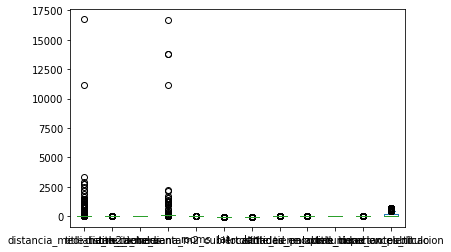

In [614]:
df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop(
    "price")].plot.box();


In [604]:
if True:
    X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
    y = df_entrenamiento_a_modelar['price']

    for n_estimators in [100, 500, 1000]:
        for max_depth in [3, 7, 11]:

            ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
            reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

            ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
            scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

            ## Imprimimos scores. Cuando más bajo mejor
            print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")


n_estimators=100, max_depth=3 --> 93657.555 +/- 59388.196
n_estimators=100, max_depth=7 --> 96049.443 +/- 58872.889
n_estimators=100, max_depth=11 --> 97364.735 +/- 56795.755
n_estimators=500, max_depth=3 --> 93683.280 +/- 59794.841
n_estimators=500, max_depth=7 --> 96305.894 +/- 58917.049
n_estimators=500, max_depth=11 --> 97093.239 +/- 57266.318
n_estimators=1000, max_depth=3 --> 93828.240 +/- 59722.413
n_estimators=1000, max_depth=7 --> 96363.659 +/- 58895.073
n_estimators=1000, max_depth=11 --> 97131.737 +/- 57294.001


In [628]:
X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
y = df_entrenamiento_a_modelar['price']


In [616]:
# version todo por 2 pesos
## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
reg = sk.ensemble.RandomForestRegressor(
    n_estimators=1000, max_depth=11, random_state=42, n_jobs=-1)

## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
scores = sk.model_selection.cross_val_score(
    reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

## Imprimimos scores. Cuando más bajo mejor
print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")


97131.737 +/- 57294.001


In [629]:
X_pred = df_prueba[X.columns]


In [630]:
n_estimators = 100
max_depth = 3

# entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
reg.fit(X, y)

# predicción
df_prueba["price"] = reg.predict(X_pred)


In [631]:
# grabo la solución
df_prueba.index.name = 'id'
df_prueba["id"] = df_prueba_inicial.id
df_prueba[["id", "price"]].to_csv(archivo_salida, index=False)


In [632]:
usuario_desea_subir_a_kaggle = (input("Subir a Kaggle? [Default: no]: ", ) or "no") in [
    "s", "S", "si", "Si", "SI", "y", "Y", "yes", "Yes", "YES"]

if ESTA_KAGGLE and usuario_desea_subir_a_kaggle:
    ! kaggle competitions submit -c fcen-md-parcial-cocheras -f $archivo_salida -m "Prueba enviar predicción desde Notebook"

if not usuario_desea_subir_a_kaggle:
    print("El resultado no se subió a Kaggle")

100%|██████████████████████████████████████| 4.20k/4.20k [00:02<00:00, 2.06kB/s]
Successfully submitted to FCEN MD 2022 Parcial Cocheras